In [1]:
import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt
import celldancer as cd
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap
import scvelo as scv
import scanpy as sc
import celldancer.utilities as cdutil
import numpy as np
import seaborn as sns

In [2]:
adata = scv.datasets.gastrulation_erythroid()

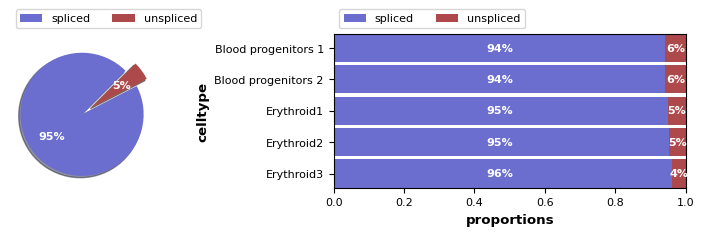

In [3]:
scv.pl.proportions(adata, groupby = "celltype")

In [4]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 47456 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
cdutil.adata_to_df_with_embed(adata,
                              us_para = ['Mu','Ms'],
                              cell_type_para = 'celltype',
                              embed_para = 'X_umap',
                              save_path = 'celldancer_predata.csv')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:56<00:00, 35.48it/s]


,gene_name,unsplice,splice,cellID,clusters,embedding1,embedding2
0,Arfgef1,0.089989,0.171288,AAAGATCTCTCGAA,Blood progenitors 2,3.460521,15.574629
1,Arfgef1,0.077669,0.213676,AATCTCACTGCTTT,Blood progenitors 2,2.490433,14.971734
2,Arfgef1,0.067421,0.222441,AATGGCTGAAGATG,Blood progenitors 2,2.351203,15.267069
3,Arfgef1,0.094973,0.160226,ACACATCTGTCAAC,Blood progenitors 2,5.899098,14.388825
4,Arfgef1,0.032490,0.103382,ACGACAACTGGAGG,Blood progenitors 2,4.823139,15.374831
...,...,...,...,...,...,...,...
19629995,Gm47283,0.153191,0.869413,TTTCACGACTGGTA,Erythroid3,8.032358,7.603037
19629996,Gm47283,0.359568,1.158716,TTTCAGTGCGAGTT,Erythroid3,10.352904,6.446736
19629997,Gm47283,0.207792,1.229323,TTTCGAACGGTGAG,Erythroid3,9.464873,7.261099
19629998,Gm47283,0.219210,1.427301,TTTCGAACTAACCG,Erythroid3,9.990495,7.243880


In [6]:
cell_type_u_s = pd.read_csv('celldancer_predata.csv')

In [7]:
loss_df, cellDancer_df = cd.velocity(cell_type_u_s, permutation_ratio = 0.125, n_jobs = 16)

Using /media/data/bmi111/KuanChiun/temp/MultiVelo/thesis/results/erythroid/cellDancer_velocity_2024-05-14 14-57-30 as the output path.
Arranging genes for parallel job.
2000  genes were arranged to  125  portions.



Velocity Estimation: 100%|██████████| 125/125 [12:21<00:00,  5.81s/it]                                                                                                                                           
                                                                                                                                                                                                                 Not predicted gene list:['Gzmg', 'Gzmf', 'Spp1', 'Nkg7']. Try visualizing the unspliced and spliced columns of the gene(s) to check the quality.


In [3]:
cellDancer_df=cd.compute_cell_velocity(cellDancer_df=cellDancer_df, projection_neighbor_choice='gene', expression_scale='power10', projection_neighbor_size=200)

Caution! Overwriting the 'velocity' columns.


Pseudo random number generator seeds are set to:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Generating Trajectories: 100%|██████████████████████████████████████████████████████████████████████████| 13970/13970 [00:00<00:00, 18519.78it/s]


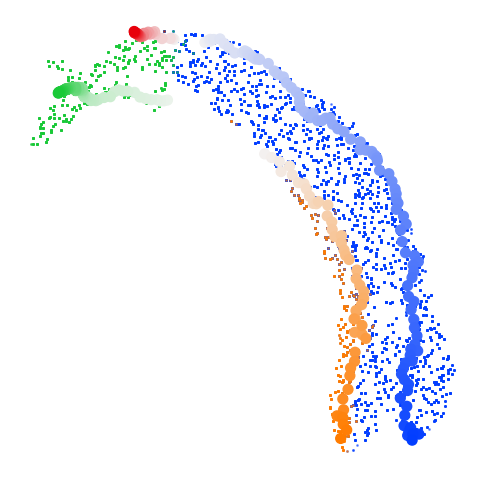

There are 3 clusters.
[0 1 2]
--- 162.804096698761 seconds ---


In [4]:
import random
# set parameters
dt = 0.05
t_total = {dt:int(10/dt)}
n_repeats = 10

# estimate pseudotime
cellDancer_df = cd.pseudo_time(cellDancer_df=cellDancer_df,
                               grid=(30,30),
                               dt=dt,
                               t_total=t_total[dt],
                               n_repeats=n_repeats,
                               speed_up=(100,100),
                               n_paths = 3,
                               plot_long_trajs=True,
                               psrng_seeds_diffusion=[i for i in range(n_repeats)],
                               n_jobs=8)

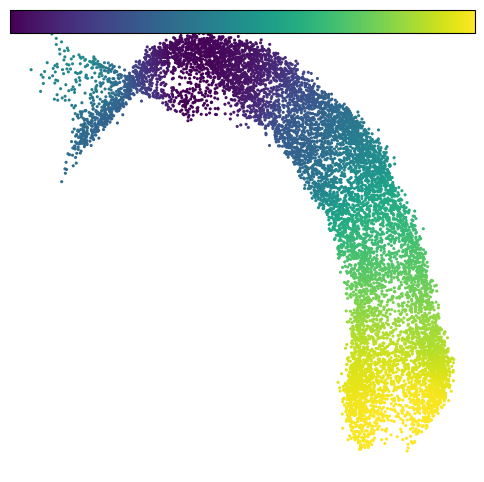

In [5]:
# plot pseudotime
fig, ax = plt.subplots(figsize=(6,6))
im=cdplt.scatter_cell(ax,cellDancer_df, colors='pseudotime', alpha=1.0, velocity=False)
ax.axis('off')
plt.show()

In [6]:
cellDancer_df.to_csv("data/celldancer_result.csv")

In [7]:
adata_celldancer = cdutil.to_dynamo(cellDancer_df)

In [8]:
clusters = list(cellDancer_df["cellID"][0:9815])

In [9]:
times = list(cellDancer_df["pseudotime"][0:9815])

In [10]:
match_dict = {k:v for k, v in zip(clusters, times)}

In [11]:
cellID = adata_celldancer.obs_names

In [12]:
pseudotime = [match_dict[item] for item in cellID]

In [13]:
adata_celldancer.obs["pseudotime"] = pseudotime

In [14]:
adata_celldancer.write_h5ad("data/celldancer.h5ad")